In [1]:
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.draw import random_shapes
import cv2
import random
from numba import njit

In [2]:
#Function to generate a dimxdim image of a random shape of a size between given bounds
def shape_gen(dim, minimum,maximum):
    x = random_shapes((dim, dim), max_shapes=1, multichannel=False, intensity_range=(0,0),min_size = minimum, max_size=maximum)[0]
    x = (-1*x+255)/255
    return(x)

In [3]:
imgDim = 16 #image dimension
mov_length = 8 

In [86]:
#Create array of start images
images_seq = [shape_gen(imgDim,4,10) for i in range(100)]
images_seq = np.array(images_seq)
images_seq = np.expand_dims(images_seq,1)

test_seq = [shape_gen(imgDim,4,10) for i in range(101)]
test_seq = np.array(test_seq)
test_seq = np.expand_dims(test_seq,1)

In [87]:
#For a given collection of start images with (n,1,k,k), with n images of dimension k by k. Trans_range is one-sided,
#so trans_range = 4 allows translations of 4 up or down, 4 left or right. same for rot_center, how much the center of 
#rotation can shift to one-side both up/down. rot_angle is maximum angle in DEGREES
def rand_trans(data, trans_range, rot_center, rot_angle): 
#     n, row, col = data[:,0,:,:].shape
#     Index = [random.randint(0,1) for i in range(n)] #randomly choose either translation or rotation
    
#     def M_gen(i):
#         if i == 0:
#             hor = random.randint(-trans_range, trans_range)
#             ver = random.randint(-trans_range, trans_range)
#             x = np.float32([[1,0,hor],[0,1,ver]]) #create translation matrix
#         else:
#             center = (row/2+random.randint(-rot_center,rot_center),col/2+random.randint(-rot_center,rot_center))
#             angle = random.uniform(0,rot_angle)
#             x = cv2.getRotationMatrix2D(center,angle,1) #create rotation matrix
#         return(x)
    
#     Z = np.array([M_gen(i) for i in Index])
    def M_gen(i):
        hor = random.randint(-trans_range, trans_range)
        ver = random.randint(-trans_range, trans_range)
        x = np.float32([[1,0,hor],[0,1,ver]]) #create translation matrix

        return(x)

    Z = np.array([M_gen(i) for i in range(data.shape[0])])
    
    return(Z)
    

In [88]:
M = rand_trans(images_seq, 1, 0, 45)
M2 = rand_trans(test_seq, 1, 0, 45)

In [107]:
#for a given collection of start images - "data" - and their associated transformations -"transform", one for each start image-
#will generate a movie sequence of the desired length. note "data" should be np.array of shape (n,1,k,k).
def image_gen(data, transform, movie_len,imgDim):
    X = data
    for j in range(movie_len-1):
        Y = np.array([cv2.warpAffine(X[i,j],transform[i],(imgDim,imgDim)) for i in range(data.shape[0])])
        Y = np.expand_dims(Y,1) #add the second axis, which denotes time, to concatenate the images
        X = np.concatenate((X,Y),axis=1)
    
    X = X.reshape(X.shape[0],X.shape[1],X.shape[2]**2) #reshape so it's easier to work with
    return(X) 

In [108]:
# data = image_gen(images_seq, M, mov_length, imgDim)
test_raw = image_gen(test_seq, M2, mov_length, imgDim)

In [99]:
image_gen(test_seq, M2, mov_length, imgDim)

101


In [9]:
def multi_gen(test_seq, testSize, maxShapes):
    
    #Set up first array, then just loop by concatenating.
    
    test_data = test_seq[np.random.randint(0,test_seq.shape[0],maxShapes)] #choose random number of movie sequences
    test_data = np.sum(test_data,axis= 0) #sum them together
    test_data[test_data > 1] = 1 #cap images at 1
    test_data = np.expand_dims(test_data, axis = 0) #add back the extra first axis, which indexes every movie sequence
    
    for datum in range(1,testSize):
        subset = test_seq[np.random.randint(0,test_seq.shape[0],maxShapes)]
        subset = np.sum(subset,axis=0)
        subset[subset > 1] = 1
        subset = np.expand_dims(subset, axis = 0)
        test_data = np.concatenate((test_data,subset),axis=0)
    
    return(test_data)

In [10]:
test = multi_gen(data, 100, 2)

In [11]:
#Rationale: since movies of multiple objects, with overlap, will just be sum of two images with values capped at 255,
#want transforms to reflect this ceiling like behavior or else prediction might be bad. 
#Will use a smooth squashing function, tanh.

def squash(x):
    y = 1.3*np.tanh(x) #1.3 so will be approxiamtely linear on [-1,1]
    return(y)

def squash_deriv(x):
    y = 1.3*(1-np.tanh(x)**2)
    return(y)

In [486]:
numTransforms = 16
trainSteps = 1000
batchSize = 25 #training 
sparsePen = 12
derivPen = 12
epsilon = 1 #variance of normal desntiy in the smoothed bump function.
eta = .02 #learning rate of phi, the dictionary of transforms
eta2 = .02 #learning rate of beta, the transform coeff
eta3 = 300 #Learning rate of center
eta4 = 300 #Learning rate of radii
numInference = 150 #arbitrary
numInf2 = 50
betaStep = 20 #FOR TRAINED TRANSFORMS. mini cycle for beta
attStep = 20 #FOR TRAINED TRANSFORMS. mini cycle for center/radii

In [13]:
#Training algorithm, image sequences with one shape. No need to infer center/radii yet.
def timeDeriv(beta):
    #assuming beta has shape btk, where k for trans, t for length, B for number of images (usually batch size)
    
    Zeroes = np.zeros((beta.shape[0],1,beta.shape[2]))
    timeDiff = np.diff(beta, axis= 1)
    tmDiffnorm = np.linalg.norm(timeDiff, ord = 1, axis=1)#normalize across time
    deriv_part1 = tmDiffnorm/(tmDiffnorm**2+1) 
    deriv_part1 = np.expand_dims(deriv_part1, axis = 1)
    X = np.concatenate((Zeroes, timeDiff), axis=1)
    Y = np.concatenate((timeDiff,Zeroes), axis =1)
    Z = np.sign(X)-np.sign(Y)
    timeBeta = np.multiply(deriv_part1,Z)
    
    return(timeBeta)

def sparseDeriv(beta):
    #assume beta has shape btk.
    
    norm_beta = np.linalg.norm(beta,ord=1, axis=2) #normalize btk, for all batches and time
    deriv_part1 = norm_beta/(norm_beta**2+1)
    deriv_part1 = np.expand_dims(deriv_part1, axis = 2)
    sparseBeta = np.multiply(deriv_part1,np.sign(beta))
    
    return(sparseBeta)

def inferBeta(Input, Output, phi, sparsePen, derivPen, eta2):
    #Assume data has shape (B, T, n2), where number of images(usually batch size) , T is time, and n2 is n^2 for nxn image
    #phi is of shape (i,i',k) where i,i' denote image dim, k denotes transform, T is time, and B is batch
    #Input are first T-1 frames. Output are frames 2 to T. Infer i^th frame from previous.
    
    beta = np.zeros((Input.shape[0],Input.shape[1],phi.shape[2])) #initialize beta at 0. beta is shape btk
    
    for step in range(numInference):
        predictions = np.einsum('btk,ijk,btj -> bti', beta, phi, Input,optimize=True)
        dTanh = squash_deriv(predictions)
        error = Output - squash(predictions)
        dBeta = np.einsum('bti,ijk,btj, btj -> btk', error, phi, dTanh, Input, optimize=True) - sparsePen*np.sign(beta) - derivPen*timeDiff(beta)
        beta += eta2*dBeta
        
    return(beta)


    
def learnTransform(Input, Output, phi, beta, eta, batchSize):
    
    predictions = np.einsum('btk,ijk,btj -> bti', beta, phi, Input, optimize=True)
    error = Output - squash(predictions)
    dTanh = squash_deriv(predictions)
    dPhi = np.einsum('bti, btj, btj, btk -> ijk', error, dTanh, Input, beta, optimize=True)
    phi += (eta/batchSize)*dPhi
    
    return(phi)
    

In [14]:
#Traning algo, image sequences with one shape.

def Training1(dataset, trainSteps, batchSize, sparsePen, derivPen, eta, eta2, numInference, numTransforms):
    
    #intialize phi
    dim = dataset.shape[2]
    phi = np.zeros(dim, dim ,numTransforms) #n2 x n2 x 15
    
    #start training
    for trial in range(trainSteps):
        
        data_batch = dataset[np.random.randint(0,dataset.shape[0],batchSize)] #create random batch
        Input = data_batch[:,:(dataset.shape[1]-1),:] #will predict next frame from these
        Output = data_batch[:,1:,:] #the frames to be predicted
        
        #Find beta, fix, then optimize phi
        beta = inferBeta(Input, Output, phi, sparsePen, derivPen, eta2)
        phi = learnTransform(Input, Output, phi, beta, eta, batchSize)
        
        #renormalize by capping absolute value to 1
        phi = phi/(np.abs(phi).max(axis=(0,1),keepdims=True))
        
        print(trial, end='\r')
        
    
    return(phi)
    

In [ ]:
# dim = data.shape[2]
# phi = np.random.rand(dim, dim ,numTransforms) #n2 x n2 x 15

# data_batch = data[np.random.randint(0,data.shape[0],batchSize)] #create random batch
# Input = data_batch[:,:(data.shape[1]-1),:] #will predict next frame from these
# Output = data_batch[:,1:,:] #the frames to be predicted



In [ ]:
learnedPhi = Training1(data, trainSteps, batchSize, sparsePen, derivPen, eta, eta2, numInference, numTransforms)

In [ ]:
#np.save("Trial2_learnedPhiv2", learnedPhiv2)

In [15]:
learnPhi = np.load("Trial2_learnedPhi8.npy")

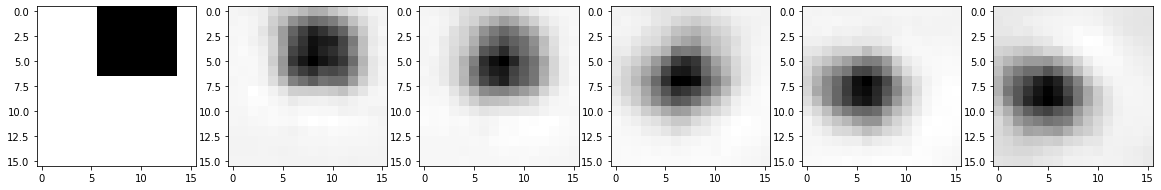

In [21]:
fig = plt.figure(figsize=(20,20)) #image sequence from dataset
for i in range(6):
        fig.add_subplot(1,6,i+1)
        plt.imshow((np.linalg.matrix_power(learnPhi[:,:,8],i)@data[14,i]).reshape((imgDim,imgDim)),cmap = "Greys")

In [264]:
normal_matrix = normalMatrix(movie_length, dim, center, radius2, epsilon)
normal_matrix.shape

(16, 7, 16, 16)

In [432]:
def diffMat(movie_length, dim, center, radius2):    
    diff_mat = np.empty((2,center.shape[2], movie_length, dim, dim)) #shape 2ktdd
    
    for k in range(center.shape[2]):
        for t in range(movie_length):
            for i in range(dim):
                for j in range(dim):
                    diff_mat[:,k,t,i,j] = (np.array([i,j])-center[:,t,k])

                        
    return(diff_mat)


In [433]:
def norm_dens(x ,epsilon):
    z = (1/np.sqrt(2*np.pi*epsilon))*np.exp((-(x**2))/(2*epsilon))
    return(z)

In [430]:
testDiff = diffMat(movie_length, dim, center, radius2)

In [471]:
norm_dens

<function __main__.norm_dens(x, epsilon)>

In [239]:
def norMat_dist:
    normal_matrix = np.empty((center.shape[2], movie_length, dim,dim)) #shape is ktdd, where k is number of transforms, t is time, d is dim of image
    
    for k in range(center.shape[2]):
        for t in range(movie_length):
            for i in range(dim):
                for j in range(dim):
                    normal_matrix[k,t,i,j] = (1/np.sqrt(2*np.pi*epsilon))*np.exp(-(radius2[t,k]-np.linalg.norm(np.array([i,j])-center[:,t,k])**2)**2/(2*epsilon**2))
    
    return(normal_matrix)

def center_ParDeriv(movie_length, dim, center, radius2, epsilon): #calculates partial deriv for center, where each entry is 2-vector
    normal_matrix = normalMatrix(movie_length, dim, center, radius2, epsilon)
    distance_pd = np.empty((2,center.shape[2], movie_3length, dim, dim)) #shape 2ktdd
    for i in range(dim):
        for j in range(dim):
            for t in range(movie_length):
                for k in range(center.shape[2]):
                    distance_pd[:,k,t,i,j] = 2*(np.array([i,j])-center[:,t,k])
            
    centerPD = np.multiply(distance_pd, normal_matrix)
    return(centerPD)

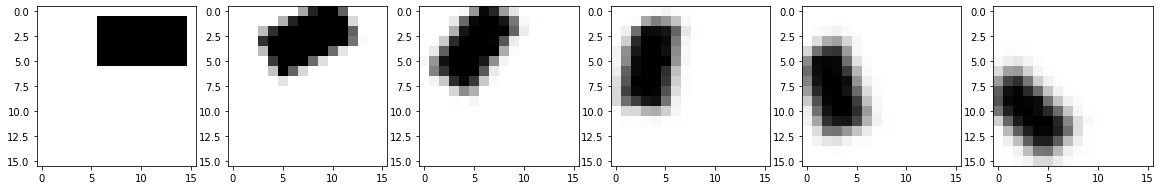

In [386]:
testImgs2 = localImage(Input2, movie_length, dim, center, radius2, epsilon)
fig = plt.figure(figsize=(20,20)) #image sequence from dataset
for i in range(6):
        fig.add_subplot(1,6,i+1)
        plt.imshow(testImgs2[0,i],cmap = "Greys")

In [353]:
def localImage(Input2, movie_length, dim, center, radius2, epsilon):
    local_matrix = np.empty((center.shape[2], movie_length, dim,dim)) #shape is ktdd, where k is number of transforms, t is time, d is dim of image
    
    for k in range(center.shape[2]):
        for t in range(movie_length):
            for i in range(dim):
                for j in range(dim):
                    local_matrix[k,t,i,j] = np.linalg.norm(np.array([i,j])-center[:,t,k])/radius2[t,k]
    local_matrix[local_matrix <= 1+ epsilon] = 1
    local_matrix[local_matrix > 1 + epsilon] = 0
    
    LocalInput2 = np.multiply(local_matrix, Input2)
    
    return(LocalInput2)

In [26]:
def InferRadius2(Input2, center, Output, radius2, phi, beta, eta3, epsilon, attStep, movie_length, dim):
    
    for step in range(attStep):
    
        localimg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input2.shape[1]**2)) #calculate localized images and reshape
        
        predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, localimg, optimize=True)
        error = Output - squash(predictions)
        dTanh = squash_deriv(predictions)
        ParDeriv = np.multiply(normalMatrix(movie_length, dim, center, radius2, epsilon), Input2).reshape((center.shape[2],movie_length, Input2.shape[1]**2))
        #ParDeriv: each entry of matrix, reshaped as vector, is derivative of localized image wrt radius2
        dR = np.einsum('ti, tk, ijk, tj, ktj -> tk', error, beta, phi, dTanh, ParDeriv, optimize=True)
        radius2 += eta3*dR
                                                                                                                      
                                                                                                                
    return(radius2)      

In [27]:
def InferCenter(Input2, center, Output, radius2, phi, beta, eta4, epsilon, attStep, movie_length, dim):
    
    for step in range(attStep):
    
        localimg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input2.shape[1]**2)) #calculate localized images and reshape
        
        predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, localimg, optimize=True)
        error = Output - squash(predictions)
        dTanh = squash_deriv(predictions)
        distance = dist_Mat(movie_length, dim, center, radius2)
        PD_1 = norm_dens(distance)
        PD_2 = np.ones_like(distance)
        PD_2 = np.einsum('tk,')
        centerPD = (1/epsilon)*(localimg)
        centerPD = .reshape((2,center.shape[2],movie_length, Input2.shape[1]**2))
        #ParDeriv: each entry of matrix, reshaped as vector, is derivative of localized image wrt radius2
        dC = np.einsum('ti, tk, ijk, cktj -> ctk', error, beta, phi, centerPD, optimize=True)
        center += eta4*dC
                                                                                                                      
                                                                                                                
    return(center)        

In [467]:
def InferNbd(Input2, center, Output, radius2, phi, beta, eta3, eta4, epsilon, attStep, movie_length, dim):
    for step in range(attStep):
        localimg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input2.shape[1]**2)) #calculate localized images and reshape
        
        predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, localimg, optimize = True)
        error = Output - squash(predictions)
        dTanh = squash_deriv(predictions)
        diff = diffMat(movie_length, dim, center, radius2)
        dist = np.linalg.norm(diff,axis=0)+.01
        rad_mat = np.ones_like(dist)
        rad_mat = np.multiply(rad_mat,np.expand_dims(np.expand_dims(radius2.T, axis=2), axis = 3)) #array where kt is radius over all ij entries
        PD_1 = norm_dens(dist, epsilon)
        PD_2 = norm_dens(dist-rad_mat, epsilon)
        PD_2 = (1/epsilon)*np.multiply(PD_1 - PD_2, diff/dist).reshape((2,center.shape[2],movie_length, Input2.shape[1]**2))                
        centerPD = np.multiply(localimg, PD_2)
        radPD = (1/epsilon)*np.multiply(localimg, PD_1.reshape(center.shape[2],movie_length, Input2.shape[1]**2)) #radius partial deriv
        
        
        dR = np.einsum('ti, tk, ijk, tj, ktj -> tk', error, beta, phi, dTanh, radPD, optimize= True)
        radius2 += eta3*dR
        dC = np.einsum('ti, tk, ijk, tj, cktj -> ctk', error, beta, phi, dTanh, centerPD, optimize = True)
        center += eta4*dC
    return(radius2,center)

In [29]:
def InferBeta2(Input2, center, Output, radius2, phi ,beta, eta, epsilon, betaStep, movie_length, dim):
    
    for step in range(betaStep):
        
        localimg = localImage(Input2, Input2.shape[0], dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input2.shape[1]**2)) #calculate localized images and reshape
        
        predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, localimg, optimize=True)
        error = Output - squash(predictions)
        dTanh = squash_deriv(predictions)
        dBeta = np.einsum('ti,ijk, tj, ktj -> tk', error, phi, dTanh, localimg, optimize=True) - sparsePen*sparseDeriv(np.expand_dims(beta,axis=0))[0,:,:] - derivPen*timeDeriv(np.expand_dims(beta,axis=0))[0,:,:]
        #just a bit of reshaping magic above to make the functions work, since sparse/derivPen made for data with extra batch dim
        beta += eta2*dBeta
    
    return(beta)

In [468]:
def InferLocal(movie_seq, phi, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInference): 
    #now want to infer beta, center, and radii for a single movie sequence
    #***RADII ARE SQUARED, to make computing the derivative easier***
    #assume movie sequence is shape txn2, where t is length (movie_length) and n2 is product of dimensions of 2d image
    
    dim = int(np.sqrt(movie_seq.shape[1]))
    Input = movie_seq[:(movie_seq.shape[0]-1)]
    Output = movie_seq[1:]
    Input2 = Input.reshape((Input.shape[0],dim,dim)) #just reshape to make region of interest indices more natural
    movie_length = Input2.shape[0]
    
    beta = np.zeros((Input2.shape[0],phi.shape[2])) #initialize beta at 0. beta is shape tk. movie_seq first dim is t
    center = (dim/2)*np.ones((2,movie_length,phi.shape[2])) #shape 2tk (2 since center is 2-vector). initialize centers at center of image. each center is 2-vector
    radius2 = ((dim/2+1)**2)*np.ones((movie_length,phi.shape[2])) # shape tk.initialize radius2 at 17^2, so start off region of interest as entire image
    
    for bigStep in range(numInference):
        beta1 = InferBeta2(Input2, center, Output, radius2, phi ,beta, eta, epsilon, betaStep, movie_length, dim)
        radius2, center = InferNbd(Input2, center, Output, radius2, phi, beta1, eta3, eta4, epsilon, attStep, movie_length, dim)
        print(bigStep, end = '\r')
    
    finalImg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input.shape[1]))
    final_predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, finalImg, optimize = True)
    
    fig = plt.figure(figsize = (20,6)) #plot the figures, top is ground truth, bottom is predictions
    for i in range(movie_length):
        for j in range(2):
            fig.add_subplot(2,movie_length,movie_length*j+i+1)
            if j == 0:
                plt.imshow(Output[i].reshape((dim,dim)),cmap = "Greys")
            else: 
                plt.imshow(final_predictions[i].reshape((dim,dim)),cmap="Greys")
    
    return((beta,radius2,center))


In [52]:
def InferLocal2(movie_seq, phi, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInference): 
    #now want to infer beta, center, and radii for a single movie sequence
    #***RADII ARE SQUARED, to make computing the derivative easier***
    #assume movie sequence is shape txn2, where t is length (movie_length) and n2 is product of dimensions of 2d image
    
    dim = int(np.sqrt(movie_seq.shape[1]))
    Input = movie_seq[:(movie_seq.shape[0]-1)]
    Output = movie_seq[1:]
    Input2 = Input.reshape((Input.shape[0],dim,dim)) #just reshape to make region of interest indices more natural
    movie_length = Input2.shape[0]
    
    beta = np.zeros((Input2.shape[0],phi.shape[2])) #initialize beta at 0. beta is shape tk. movie_seq first dim is t
    center = (dim/2)*np.ones((2,movie_length,phi.shape[2])) #shape 2tk (2 since center is 2-vector). initialize centers at center of image. each center is 2-vector
    radius2 = (17**2)*np.ones((movie_length,phi.shape[2])) # shape tk.initialize radius2 at 17^2, so start off region of interest as entire image
    
    for bigStep in range(numInference):
        beta = InferBeta2(Input2, center, Output, radius2, phi ,beta, eta, epsilon, betaStep, movie_length, dim)
        radius2 = InferRadius2(Input2, center, Output, radius2, phi, beta, eta3, epsilon, attStep, movie_length, dim)
        center = InferCenter(Input2, center, Output, radius2, phi, beta, eta4, epsilon, attStep, movie_length, dim)
        print(bigStep)
    
    finalImg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input.shape[1]))
    final_predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, finalImg, optimize = True)
    
    fig = plt.figure(figsize = (20,6)) #plot the figures, top is ground truth, bottom is predictions
    for i in range(movie_length):
        for j in range(2):
            fig.add_subplot(2,movie_length,movie_length*j+i+1)
            if j == 0:
                plt.imshow(Output[i].reshape((dim,dim)),cmap = "Greys")
            else: 
                plt.imshow(final_predictions[i].reshape((dim,dim)),cmap="Greys")
    
    return((beta,radius2,center))


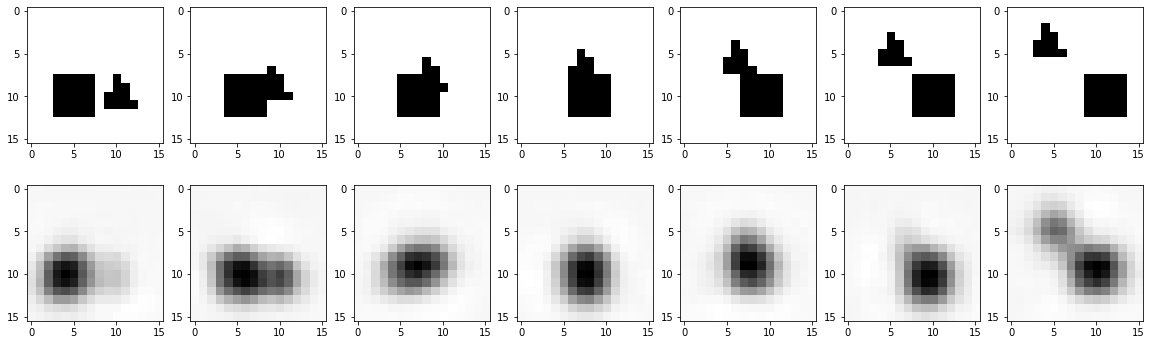

In [487]:
testrun2 = InferLocal(test[20], learnPhi, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInf2)

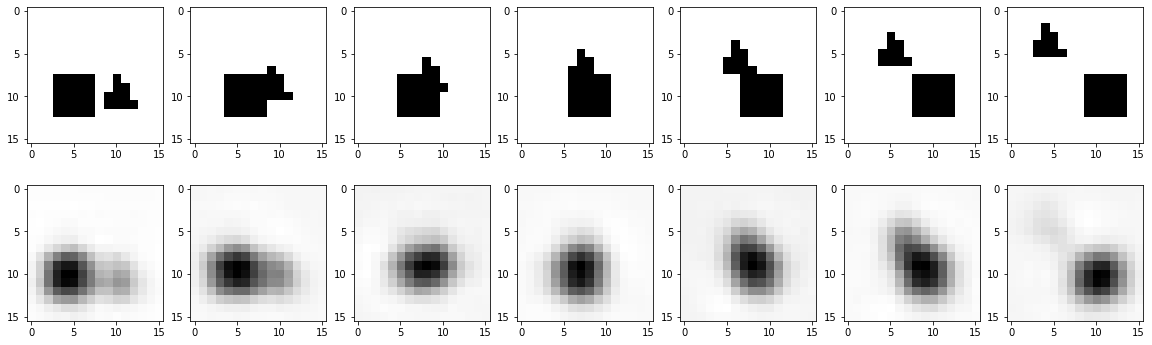

In [36]:
testrun = InferLocal(test[20], learnPhi, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInf2)

In [ ]:
infertBeta
final_predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, test[20], optimize = True)

fig = plt.figure(figsize = (20,6)) #plot the figures, top is ground truth, bottom is predictions
for i in range(movie_length):
    for j in range(2):
        fig.add_subplot(2,movie_length,movie_length*j+i+1)
        if j == 0:
            plt.imshow(Output[i].reshape((dim,dim)),cmap = "Greys")
        else: 
            plt.imshow(final_predictions[i].reshape((dim,dim)),cmap="Greys")

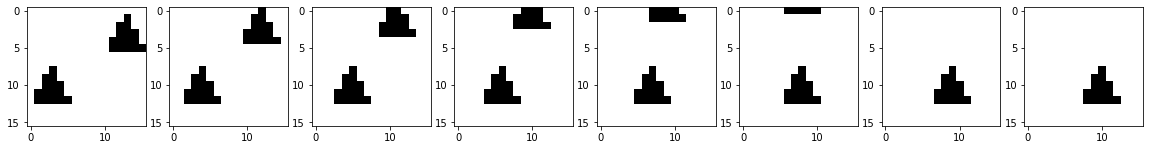

In [35]:
fig = plt.figure(figsize=(20,20)) #image sequence from dataset
for i in range(mov_length):
        fig.add_subplot(1,mov_length,i+1)
        plt.imshow(test[8,i].reshape((imgDim,imgDim)),cmap = "Greys")

In [472]:
testrun_info = testrun[:2]
testrun2_info = testrun2[:2]

In [ ]:
fig_testrun = plt.figure(figsize=(20,20)) #image sequence from dataset
for i in range(2):
        fig_testrun.add_subplot(1,2,i+1)
        plt.bar(list(range(16)), (testrun_info[i])[0,:])

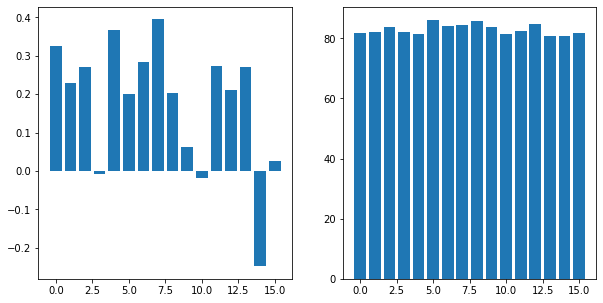

In [492]:
fig_testrun = plt.figure(figsize=(10,5)) #image sequence from dataset
for i in range(2):
        fig_testrun.add_subplot(1,2,i+1)
        plt.bar(list(range(16)), (testrun2_info[i])[1,:])

In [ ]:
plt.bar(list(range(16)),testradius2[3,:])